<a href="https://colab.research.google.com/github/Ponter255/cuddly-chainsaw/blob/master/Adverse_Events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adverse Events

*   Create a NLP model that can predict a adverse event.

---

### 1. Modelling Database

* First we need to clean the database and pick up only the useful information.

In [0]:
from sklearn.naive_bayes                     import MultinomialNB
from sklearn.feature_extraction.text         import CountVectorizer
from collections                             import Counter
from sklearn.model_selection                 import train_test_split
from sklearn.feature_extraction.text         import TfidfTransformer
from IPython.display                         import Image, display
from IPython.core.display                    import HTML
from numpy.random                            import randint
from matplotlib.pyplot                       import figure
from sklearn.ensemble                        import RandomForestClassifier
from sklearn.svm                             import SVC
from sklearn.metrics                         import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline                        import Pipeline
from sklearn.feature_extraction.text         import TfidfVectorizer
from nltk.corpus                             import stopwords
from bs4                                     import BeautifulSoup
from collections                             import defaultdict
from nltk.corpus                             import stopwords
import pandas                                as pd
import matplotlib.pyplot                     as plt
import string
import operator
import functools
import nltk
import urllib.request


dataset = pd.read_csv('Adverse Events.csv', sep = ';', encoding = "utf-8", error_bad_lines=False)
dataset

,Qual idade do paciente?,Qual medicamento que o paciente faz uso?,Houve relato de evento adverso e/ou situação especial?,Relator:,Medicamento suspeito:,Descrição do relato de farmacovigilância,Autorização de contato:,Confirmação da data do contato,Assunto abordado:
0,25.0,Esbriet,Sim,Paciente,N,N,Sim,03/09/2018,Teste
1,20.0,Não iniciou o tratamento ainda,Sim,Cuidador,Seguro,Não,Sim,21/09/2018,Todos
2,61.0,Não iniciou o tratamento ainda,Não,NaN,NaN,NaN,NaN,NaN,espera pela liberação do medicamento
3,71.0,Não iniciou o tratamento ainda,Não,NaN,NaN,NaN,NaN,NaN,"espera pelo medicamento e bem estar, diposição..."
4,68.0,Esbriet,Sim,Paciente,esbriet,começa a ficar com um pouco de sono uns 20 min...,Sim,10/11/2018,sintomas físicos em geral
...,...,...,...,...,...,...,...,...,...
1085,73.0,Esbriet,Sim,Paciente,esbriet,Teve pneumonia estes dias; hoje tomou o último...,"Sim, autoriza contato com o paciente., Sim, au...",25/10/2019,tratamento e saúde
1086,70.0,Esbriet,Não,NaN,NaN,NaN,NaN,NaN,saúde do paciente
1087,68.0,Esbriet,Sim,Paciente,esbriet,PAciente diz que perdeu toda a massa muscular...,"Sim, autoriza contato com o paciente., Sim, au...",26/10/2019,saúde física e mental
1088,69.0,Esbriet,Sim,Paciente,esbriet,Paciente referiu que seus últimos exames apont...,"Sim, autoriza contato com o paciente., Sim, au...",26/10/2019,saúde


In [0]:
# Check how many fields are null in the dataset
dataset.isnull().sum()

Qual idade do paciente?                                     2
Qual medicamento que o paciente faz uso?                    0
Houve relato de evento adverso e/ou situação especial?      0
Relator:                                                  482
Medicamento suspeito:                                     482
Descrição do relato de farmacovigilância                  482
Autorização de contato:                                   482
Confirmação da data do contato                            482
Assunto abordado:                                           0
dtype: int64

In [0]:
len(dataset)

1090

In [0]:
# Target of the dataset
indexResult = 2
#Starting feature of the dataset
indexReport = 5


# Selecting reporting rows
feature = dataset.iloc[:,indexReport]

#Selecting result rows for Adverse Event
target = dataset.iloc[:, indexResult]

# See amount of values of each type for target
target.value_counts()

yesReports = dataset[dataset['Houve relato de evento adverso e/ou situação especial?']=='Sim']
noReports = dataset[dataset['Houve relato de evento adverso e/ou situação especial?']=='Não']

#data_train, data_test, target_train, target_test = train_test_split(feature, target, test_size=0.20, random_state=0)

In [0]:
target.shape, feature.shape

((1090,), (1090,))

### Exploratory Data Analysis

First of all let's clean our dataset from information that is not needed, such as null values

*  **.iat** - Access a single value for a row/column pair by integer position.

In [0]:
#take out null values
dataset =  dataset.dropna()
dataset

,Qual idade do paciente?,Qual medicamento que o paciente faz uso?,Houve relato de evento adverso e/ou situação especial?,Relator:,Medicamento suspeito:,Descrição do relato de farmacovigilância,Autorização de contato:,Confirmação da data do contato,Assunto abordado:
0,25.0,Esbriet,Sim,Paciente,N,N,Sim,03/09/2018,Teste
1,20.0,Não iniciou o tratamento ainda,Sim,Cuidador,Seguro,Não,Sim,21/09/2018,Todos
4,68.0,Esbriet,Sim,Paciente,esbriet,começa a ficar com um pouco de sono uns 20 min...,Sim,10/11/2018,sintomas físicos em geral
6,69.0,Não iniciou o tratamento ainda,Sim,Cuidador,nenhum,Óbito do paciente há 15 dias,Sim,10/11/2018,óbito do paciente
9,68.0,Esbriet,Sim,Paciente,esbriet,Médico reduziu dose diária para 6 cps ao dia d...,Sim,10/11/2018,dificuldade de se adaptar à cidade para a qual...
...,...,...,...,...,...,...,...,...,...
1083,78.0,Esbriet,Sim,Cuidador,esbriet,Esposa referiu que ficou desesperada com os ef...,"Sim, autoriza contato com o paciente., Sim, au...",25/10/2019,saúde do paciente
1084,78.0,Esbriet,Sim,Cuidador,esbriet,Filha contou que paciente está no terceiro vid...,"Sim, autoriza contato com o paciente., Sim, au...",25/10/2019,saúde do paciente
1085,73.0,Esbriet,Sim,Paciente,esbriet,Teve pneumonia estes dias; hoje tomou o último...,"Sim, autoriza contato com o paciente., Sim, au...",25/10/2019,tratamento e saúde
1087,68.0,Esbriet,Sim,Paciente,esbriet,PAciente diz que perdeu toda a massa muscular...,"Sim, autoriza contato com o paciente., Sim, au...",26/10/2019,saúde física e mental


> Giving the data some negative answers in which we can improve the trainning of the model in order to have a better result                                   

In [0]:
negativeReport = {'Qual idade do paciente?':20, 
           'Qual medicamento que o paciente faz uso?':'Esbriet', 
            'Houve relato de evento adverso e/ou situação especial?':'Não', 
           'Relator:':'Paciente', 'Medicamento suspeito:':'esbriet',
           'Descrição do relato de farmacovigilância':'Hoje tomei o remédio e meu pé começou a coçar, e logo depois de sair da cama de manhã comecei a me sentir um pouco tonto, mas essa sensação passou rápido',
           'Autorização de contato:':'Sim',
           'Confirmação da data do contato':'03/09/2018',
           'Assunto abordado:':'saúde do paciente'}

negativeReport2 = {'Qual idade do paciente?':20, 
           'Qual medicamento que o paciente faz uso?':'Esbriet', 
            'Houve relato de evento adverso e/ou situação especial?':'Não', 
           'Relator:':'Paciente', 'Medicamento suspeito:':'esbriet',
           'Descrição do relato de farmacovigilância':'Após começar a tomar o remédio diariamente, como o médico recomendou, além de de servir seu propósito comecei a me sentir mais disposto de manhã, além da dor nas costas desaparecer.',
           'Autorização de contato:':'Sim',
           'Confirmação da data do contato':'03/09/2018',
           'Assunto abordado:':'saúde do paciente'}
  
negativeReport3 = {'Qual idade do paciente?':20, 
           'Qual medicamento que o paciente faz uso?':'Esbriet', 
            'Houve relato de evento adverso e/ou situação especial?':'Não', 
           'Relator:':'Paciente', 'Medicamento suspeito:':'esbriet',
           'Descrição do relato de farmacovigilância':'Normalmente sinto muita dor de cabeça, principalmente na parte da tarde, desde que comecei a tomar o remédio essas dores pararam',
           'Autorização de contato:':'Sim',
           'Confirmação da data do contato':'03/09/2018',
           'Assunto abordado:':'saúde do paciente'}

negativeReport4 = {'Qual idade do paciente?':20, 
           'Qual medicamento que o paciente faz uso?':'Esbriet', 
            'Houve relato de evento adverso e/ou situação especial?':'Não', 
           'Relator:':'Paciente', 'Medicamento suspeito:':'esbriet',
           'Descrição do relato de farmacovigilância':'Hoje tomei o remédio e meu pé começou a coçar, e logo depois de sair da cama de manhã comecei a me sentir um pouco tonto, mas essa sensação passou rápido',
           'Autorização de contato:':'Sim',
           'Confirmação da data do contato':'03/09/2018',
           'Assunto abordado:':'saúde do paciente'}

negativeReport5 = {'Qual idade do paciente?':20, 
           'Qual medicamento que o paciente faz uso?':'Esbriet', 
           'Houve relato de evento adverso e/ou situação especial?':'Não', 
           'Relator:':'Cuidador', 
           'Medicamento suspeito:':'esbriet',
           'Descrição do relato de farmacovigilância':'Paciente que normalmente possue falta de disposição começou a se comportar de fomra diferente diante das pessoas',
           'Autorização de contato:':'Sim',
           'Confirmação da data do contato':'03/09/2018',
           'Assunto abordado:':'saúde do paciente'}

dataset = dataset.append(negativeReport, ignore_index=True)
dataset = dataset.append(negativeReport2, ignore_index=True)
dataset = dataset.append(negativeReport3, ignore_index=True)
dataset = dataset.append(negativeReport4, ignore_index=True)
dataset = dataset.append(negativeReport5, ignore_index=True)

In [0]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a dataframe for analysis

In [0]:
analysis = pd.DataFrame(columns=['Result','Report','Length'])
punc=0
i=0
while i < len(dataset):
  result = dataset.iat[i, 2]
  report = dataset.iat[i, 5] 
  length = len(str(report))
  new_row = {'Result':result,'Report':report, 'Length':length}
  #append row to the dataframe
  analysis = analysis.append(new_row, ignore_index=True)
  i += 1

analysis = analysis.drop([0,1],axis=0)
print(analysis)

    Result                                             Report Length
2      Sim  começa a ficar com um pouco de sono uns 20 min...     76
3      Sim                       Óbito do paciente há 15 dias     28
4      Sim  Médico reduziu dose diária para 6 cps ao dia d...    142
5      Sim  Paciente às vezes toma 6 cps ao dia, às vezes ...    133
6      Sim  No mês passado, muitas dores no corpo (doía at...    207
..     ...                                                ...    ...
606    Não  Hoje tomei o remédio e meu pé começou a coçar,...    153
607    Não  Após começar a tomar o remédio diariamente, co...    181
608    Não  Normalmente sinto muita dor de cabeça, princip...    128
609    Não  Hoje tomei o remédio e meu pé começou a coçar,...    153
610    Não  Paciente que normalmente possue falta de dispo...    112

[609 rows x 3 columns]


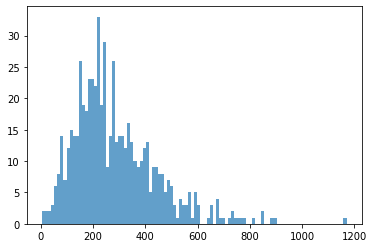

In [0]:
%matplotlib inline
plt.hist(analysis[analysis['Result']=='Sim']['Length'], bins = 100, alpha = 0.7)
plt.show()

In [0]:
stopwords.append('Paciente')
stopwords.append('o')
stopwords.append('esbriet')
stopwords.append('paciente')
stopwords.append('esbriet.')
stopwords.append('Não')
stopwords.append('não')
stopwords.append('está')
stopwords.append('se')
stopwords.append('ele')

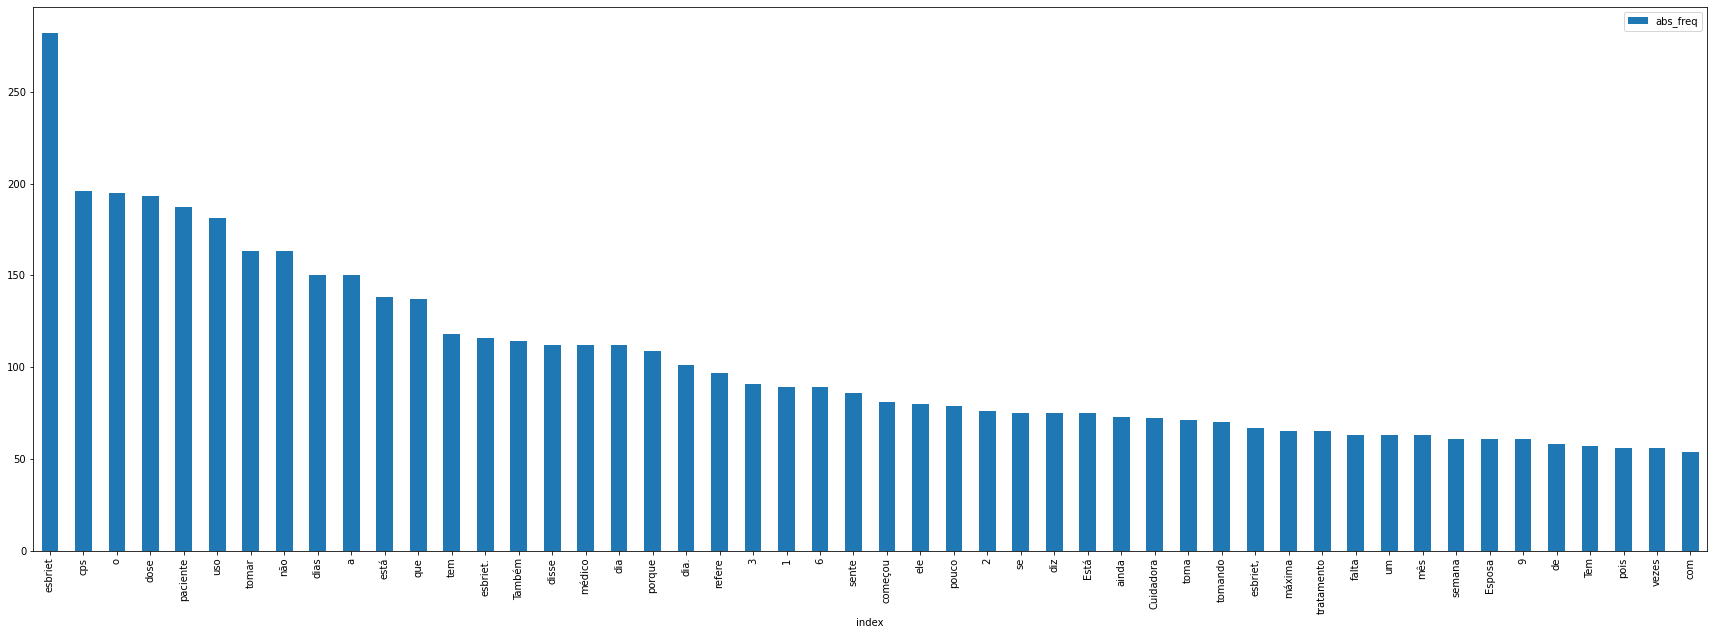

In [0]:
textList = analysis['Report'].to_list()

cleanList = []


i=0
while i < len(textList):
   tokens =  textList[i].split()
   i+=1
   clean_tokens = tokens
   for token in tokens:
    if token in stopwords:
         clean_tokens.remove(token)
   cleanList.append(clean_tokens)


word_freq = defaultdict(int)

for item in cleanList:
    for word in item:
        word_freq[word] += 1

teste = pd.DataFrame.from_dict(word_freq, orient='index') \
.sort_values(0, ascending=False) \
.rename(columns={0: 'abs_freq'})

teste = teste.reset_index()

teste = teste.head(50)

teste.plot(kind='bar',x='index',y='abs_freq', figsize=(30, 10))


## Applying NLP

> ***sklearn.feature_extraction.text.TfidfVectorizer***: Convert a collection of raw documents to a matrix of **TF-IDF features**.

*  In information retrieval, **TF-IDF**, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection.

*  It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word.



In [0]:
#This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
feature_train, feature_test, result_train, result_test = train_test_split(analysis['Report'], analysis['Result'], test_size = 0.4, random_state=0)

vectorizer = TfidfVectorizer()
feature_vect = vectorizer.fit_transform(feature_train)

feature_vect.shape

(365, 2218)

### Pipeline 

* The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

---
> **class sklearn.pipeline.Pipeline(steps, memory=None, verbose=False)**

* **stepslist**: 

List of (name, transform) tuples (implementing fit/transform) that are chained, in the order in which they are chained, with the last object an estimator.

* **memoryNone**:

Used to cache the fitted transformers of the pipeline. By default, no caching is performed. If a string is given, it is the path to the caching directory. Enabling caching triggers a clone of the transformers before fitting. Therefore, the transformer instance given to the pipeline cannot be inspected directly. Use the attribute named_steps or steps to inspect estimators within the pipeline. Caching the transformers is advantageous when fitting is time consuming.

* **verbosebool**:

default=False
If True, the time elapsed while fitting each step will be printed as it is completed.

---

[Decision Tree Algorithm](https://dataaspirant.com/2017/01/30/how-decision-tree-algorithm-works/): The information entropy, often just entropy, is a basic quantity in information theory associated to any random variable, which can be interpreted as the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes. 

![Entropy](https://wikimedia.org/api/rest_v1/media/math/render/svg/971ffd75b32f284123036d4ae8fc3dd6e377e030)

![Decision Tree](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png?resize=768%2C424&ssl=1)

---

### [Random Forest Classifier](https://dataaspirant.com/2017/05/22/random-forest-algorithm-machine-learing/)

`Random forest algorithm can use both for classification and the regression kind of problems.`

In general, the more trees in the forest the more robust the forest looks like. In the same way in the random forest classifier, the higher the number of trees in the forest gives the high accuracy results.

In random forest algorithm, Instead of using information gain or gini index for calculating the root node, the process of finding the root node and splitting the feature nodes will happen randomly.

To address the advantages of random forest algorithm, we have:

* The same random forest algorithm or the random forest classifier can use for both classification and the regression task.

* Random forest classifier will handle the missing values.

* When we have more trees in the forest, random forest classifier won’t overfit the model.

* Can model the random forest classifier for categorical values also.

![alt text](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2017/04/Random-Forest-Example.jpg?w=700&ssl=1)

---


In [0]:
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(feature_train, result_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [0]:
result_pred = clf.predict(feature_test)
print(classification_report(result_test, result_pred))

              precision    recall  f1-score   support

         Não       0.00      0.00      0.00         4
         Sim       0.98      1.00      0.99       240

    accuracy                           0.98       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.97      0.98      0.98       244



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy_score(result_test, result_pred)

0.9836065573770492

In [0]:
# Should result in "Não"
clf.predict(["Paciente esta sentindo muito bem depois de tomar o rémedio"])

array(['Sim'], dtype=object)

In [0]:
# Should result in "Não"
clf.predict(["Após tomar o remédio parei de sentir cansaço na parte da tarde"])

array(['Sim'], dtype=object)

---

### [Support Vector Machines (SVM)](https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/)


It is a fast and dependable classification algorithm that performs very well with a limited amount of data.

* Let’s imagine we have two tags: red and blue, and our data has two features: x and y. We want a classifier that, given a pair of (x,y) coordinates, outputs if it’s either red or blue.

* A support vector machine takes these data points and outputs the hyperplane (which in two dimensions it’s simply a line) that best separates the tags. This line is the decision boundary: anything that falls to one side of it we will classify as blue, and anything that falls to the other as red.


![alt text](https://monkeylearn.com/blog/wp-content/uploads/2017/06/plot_hyperplanes_annotated.png)

In [0]:
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(C = 1000, gamma = 'auto'))])
clf.fit(feature_train, result_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [0]:
result_pred = clf.predict(feature_test)
print(classification_report(result_test, result_pred))

              precision    recall  f1-score   support

         Não       0.00      0.00      0.00         4
         Sim       0.98      1.00      0.99       240

    accuracy                           0.98       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.97      0.98      0.98       244



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy_score(result_test, result_pred)

0.9836065573770492

In [0]:
# Should result in "Não"
clf.predict(["Paciente esta sentindo muito bem depois de tomar o rémedio"])

array(['Sim'], dtype=object)

---

### [Fast Text](https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3)

Previous work [here](https://docs.google.com/presentation/d/1v2Eacsg3xa8C7RJa9P_9tZQ8Q3W3sczsfHkrR3wroe0/edit#slide=id.g6d12a584d4_0_0)